# **Scrap-Website-Example**

In this first work I will try to scrap the list of seasonal fruits and vegetables from the website: https://www.lesfruitsetlegumesfrais.com/

In [1]:
import requests
from bs4 import BeautifulSoup

response = requests.get('https://www.lesfruitsetlegumesfrais.com/calendrier-fruits-legumes/fevrier')
html_content = response.content

soup = BeautifulSoup(html_content, 'html.parser')

# Find all span elements with the class 'name'
names = soup.find_all('span', class_='name')

# Extract the text from each span element
#for name in names:
#    print(name.text)

In [2]:
import pandas as pd

columns = ["Janvier", "Fevrier", "Mars", "Avril", "Mai", "Juin", "Juillet", "Aout", "Septembre", "Octobre", "Novembre", "Decembre"]
seasonal_data = pd.DataFrame()
max_length = 0
data_dict = {}
print(seasonal_data)

Empty DataFrame
Columns: []
Index: []


In [3]:
for month in columns:
    url = 'https://www.lesfruitsetlegumesfrais.com/calendrier-fruits-legumes/'
    url = url + month.lower()
    
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')

    names = soup.find_all('span', class_='name')
    month_data = [name.text for name in names]
    
    # Update max_length if current list is longer
    if len(month_data) > max_length:
        max_length = len(month_data)
    
    data_dict[month] = month_data

# Now create the DataFrame with columns of equal length
for month, month_data in data_dict.items():
    # Pad month_data if it's not the longest one
    if len(month_data) < max_length:
        month_data += [None] * (max_length - len(month_data))
    seasonal_data[month] = month_data
    
#seasonal_data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

all_items = pd.unique(seasonal_data.values.ravel('K'))
all_items = [item for item in all_items if item is not None]
all_items.sort()

sorted_seasonal_data = pd.DataFrame(index=all_items, columns=seasonal_data.columns)

for month in seasonal_data.columns:
    for item in all_items:
        sorted_seasonal_data.at[item, month] = item in seasonal_data[month].values
        
#sorted_seasonal_data

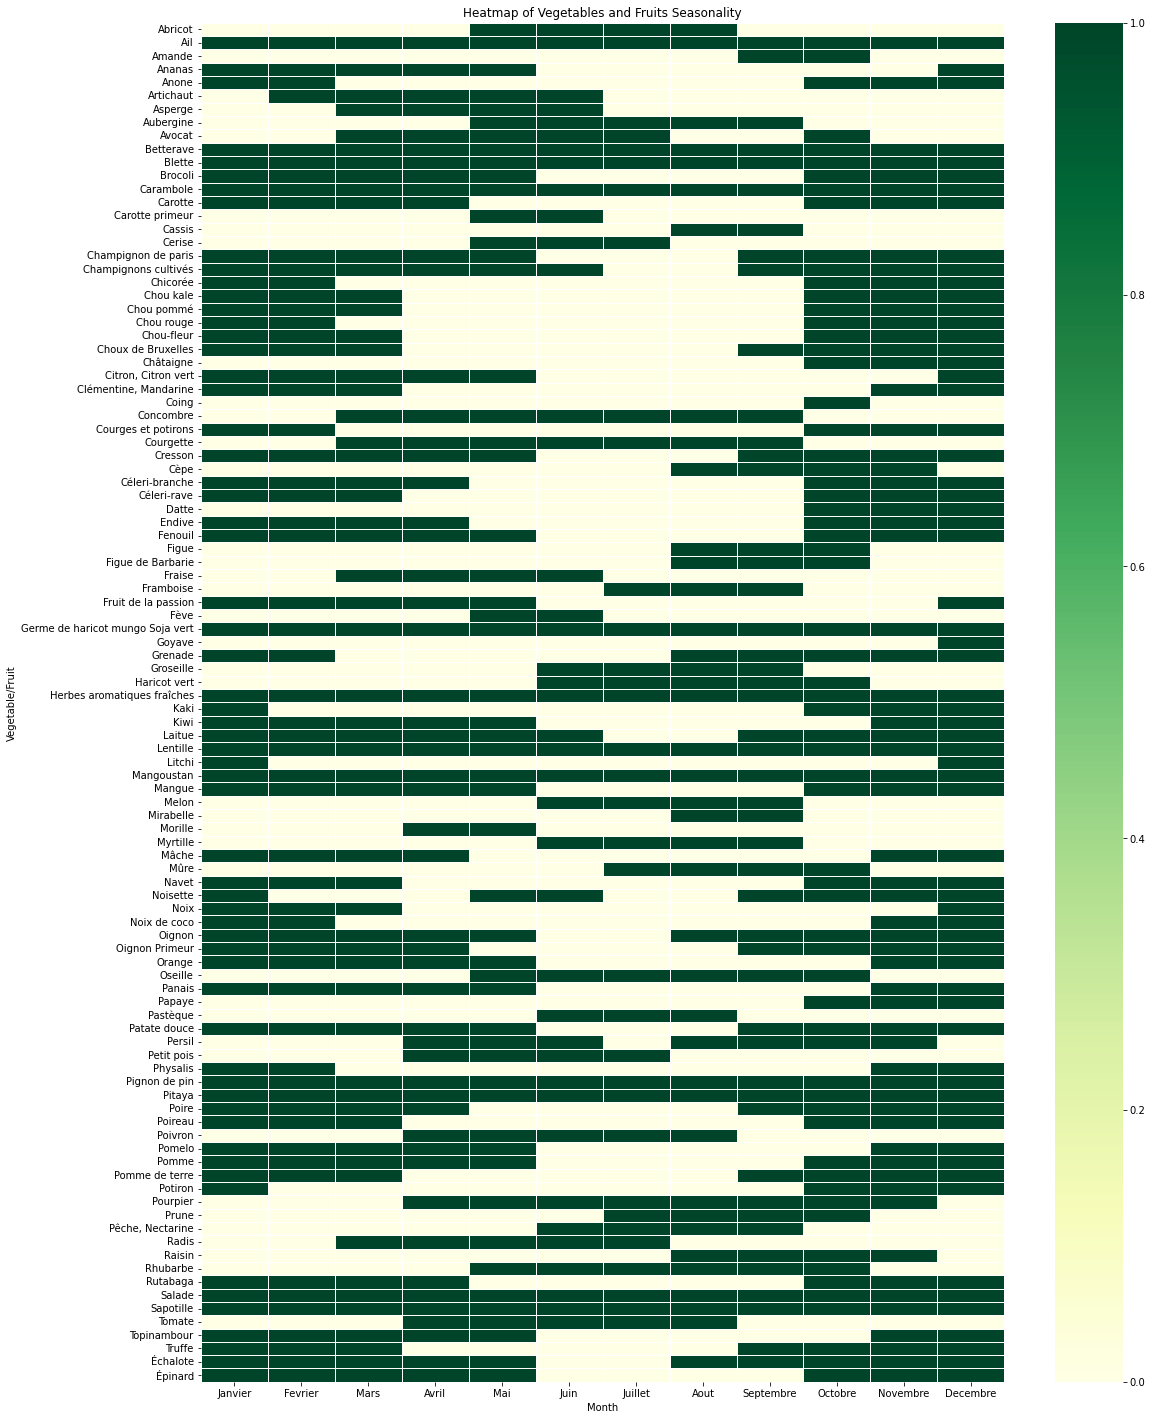

In [5]:
heatmap_data = sorted_seasonal_data.replace({True: 1, False: 0})

plt.figure(figsize=(18, 25))
sns.heatmap(heatmap_data, cmap='YlGn', linewidths=.5, annot=False)
plt.title('Heatmap of Vegetables and Fruits Seasonality')
plt.xlabel('Month')
plt.ylabel('Vegetable/Fruit')
plt.show()


Trying to scrap: https://www.opentable.fr/

In [10]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
import time

# Function to extract text from the menu section
def extract_menu_text(driver):
    try:
        WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.ID, "menu"))
        )
        
        # If no article elements are found, return an empty list immediately
        articles = driver.find_elements(By.CSS_SELECTOR, "#menu article")
        if not articles:
            print("No articles found inside the menu.")
            return []
        
        try:
            complete_menu_button = driver.find_element(By.XPATH, "//button[contains(text(), 'Voir le menu complet')]")
            
            # Click the button (Required to get all the articles and not just the visible ones)
            complete_menu_button.click()
        except NoSuchElementException:
            pass
        
        # Wait for at least one article element to appear within the menu
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "#menu article"))
        )
        
        # Find all article elements within the menu
        articles = driver.find_elements(By.CSS_SELECTOR, "#menu article")

        # For each article, find all h4 and p and extract the text
        all_texts = []
        for article in articles:
            h4_texts = [h4.text for h4 in article.find_elements(By.TAG_NAME, 'h4')]
            p_texts = [p.text for p in article.find_elements(By.TAG_NAME, 'p')]
            
            # Combine the lists and add them to the all_texts list
            all_texts.extend(h4_texts + p_texts)
        
        #return menu_texts
        return all_texts
    
    except TimeoutException:
        print("Timeout waiting for the menu to load.")
        return []

In [11]:
import re

# Function to clean up the menu item strings
def clean_menu_list(menu_list):
    combined_menu = ' '.join(menu_list)
    combined_menu = combined_menu.lower()

    # Remove numbers and special characters (keeping only words and spaces)
    cleaned_menu = re.sub(r'[^a-z\s]', '', combined_menu)

    menu_words = cleaned_menu.split()
    unique_menu_words = list(set(menu_words))

    return unique_menu_words

In [24]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.opentable.fr/")
time.sleep(1)

# Find the search input field by the 'data-test' attribute and enter 'Paris'
input_field = driver.find_element(By.CSS_SELECTOR, "input[data-test='search-autocomplete-input']")
input_field.send_keys("Paris")

# Find the search button by its 'aria-label' and click it
search_button = driver.find_element(By.CSS_SELECTOR, "button[aria-label='Rechercher']")
search_button.click()
time.sleep(1)

last_height = driver.execute_script("return document.body.scrollHeight")

# Scroll down to the bottom
for i in range(0, last_height, 300):
        driver.execute_script(f"window.scrollTo(0, {i});")
        time.sleep(0.25)
time.sleep(2)

# Now that we've scrolled the entire page, find all the cards
try:
    cards = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".multiSearchRestaurantCard"))
    )
except:
    print("Timeout waiting for the restaurant cards to load.")

# Initialize a list to hold all the data for the CSV
data_for_csv = []

# Safely iterate over each card to extract the link
for card in cards:
    main_window = driver.current_window_handle

    link_element = card.find_element(By.TAG_NAME, 'a')
    link = link_element.get_attribute('href')
    driver.execute_script("window.open(arguments[0]);", link)  # Open link in new tab
    time.sleep(1)

    # Switch to new tab
    driver.switch_to.window(driver.window_handles[1])
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))  # Wait for the page body to be present
    
    # Extract the restaurant name
    name_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'h1.E-vwXONV9nc-'))
    )
    restaurant_name = name_element.text
    
    # Get the number of stars
    try:
        stars_element = driver.find_element(By.CSS_SELECTOR, "#ratingInfo > span")
        stars = stars_element.text
    except NoSuchElementException:
        stars = ""

    # Get the price range
    try:
        price_range_element = driver.find_element(By.CSS_SELECTOR, "#priceBandInfo > span:nth-of-type(2)")
        price_range = price_range_element.text
    except NoSuchElementException:
        price_range = ""

    # Get the type of cuisine
    try:
        cuisine_element = driver.find_element(By.CSS_SELECTOR, "#cuisineInfo > span:nth-of-type(2)")
        cuisine = cuisine_element.text
    except NoSuchElementException:
        cuisine = ""
    
    print('stars: ', stars)
    print('price: ', price_range)    
    print('cuisine: ', cuisine)
    
    # Extract text from the menu
    menu_words = extract_menu_text(driver)
    print("Menu: ",menu_words)
    
    # Clean the menu items
    cleaned_menu_items = clean_menu_list(menu_words)
    print("Cleaned Menu: ", cleaned_menu_items)
    
    # Add the restaurant name and cleaned menu items to the data list
    data_for_csv.append([restaurant_name] + [stars] + [price_range] + [cuisine] + cleaned_menu_items)
    
    # Close the current tab
    driver.close()

    # Switch back to the main window
    driver.switch_to.window(main_window)
    time.sleep(1)
    
# Close the browser
driver.quit()

stars:  4.3
price:  51 € et plus
cuisine:  Française
No articles found inside the menu.
Menu:  []
Cleaned Menu:  []
stars:  4.5
price:  De 31 € à 50 €
cuisine:  Française - Traditionnelle
Menu:  ['Scallop Tartare\n16,50 €', "Grandmother's Soup of the Moment\n9,50 €", 'Roasted Figs Stuffed with Goat Cheese\n13,00 €', 'Xl Burgundy Snails\n11,50 €', 'Onion Soup au Gratin*\n14,50 €', 'Foie Gras From the South West\n24,00 €', 'Roasted Marrow Bone XXL*\n12,00 €', 'Organic Eggs and Home-Made Mayonnaise*\n8,50 €', 'Monseigneur Pasta des Enfants Gâtés*\n21,50 €', '7-Hour Lamb\n34,00 €', 'Roasted Vegetable Mille-feuille\n22,50 €', 'Sesame and Lime-Crusted Tuna\n32,00 €', 'Frenchy Burger*\n24,00 €', 'Salmon Blanquette\n26,50 €', 'Angus Beef Pear (250g)\n32,00 €', 'Whole AOP French South-West Duck Breast\n36,00 €', 'Charolais Beef Tartar*\n23,00 €', "Chef's Casserole for one\n26,00 €", "Chef's Casserole for 2\n46,00 €", 'Pork Tenderloin (Filet Mignon)\n24,50 €', 'Roast Chicken*', 'Pork Ribs XXL*\n

In [25]:
import csv

# Write the data to a CSV file
with open('restaurants.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Optionally write a header row, if you want
    writer.writerow(['Restaurant_Name', 'Ranking', 'Price_Range', 'Cuisine_Type', 'Menu Items'])
    writer.writerows(data_for_csv)

print("CSV file has been created.")

CSV file has been created.


### To do:
- Get other pages of restaurants
- Translate list of ingredients in french
- Make a json with name of restaurant and list of ingredients

### To do for other group member's:
- Scrap for each restaurant: average price, number of star, location, type of restaurant (french, italian,...)
- Get a json with name of the restaurant and all these data in french

#### Then with these two json we will be able to make some analyses and graphs.